In [1]:
!pip install rouge-score

In [11]:
from rouge_score import rouge_scorer
from rouge_score import scoring
import sys
sys.path.append('/Users/skylerroh/mids/tldr-reddit-summarization')
from preprocess import utils
import sentencepiece as spm
import numpy as np

In [4]:
CONTENT_KEY = 'inputs'
SUMMARY_KEY = 'targets'

In [5]:
sp = spm.SentencePieceProcessor(model_file="../../pegasus/ckpt/pegasus_ckpt/c4.unigram.newline.10pct.96000.model")

In [6]:
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL", "rougeLsum"], use_stemmer=True)

In [7]:
def encodeSPTokens(example):
    return sp.encode(example)

def decodeStartingTokens(tokens, n):
    return sp.decode(tokens[:n])

def decodeEndTokens(tokens, n):
    if len(tokens) >= n:
        return sp.decode(tokens[(len(tokens)-n):])
    else:
        return sp.decode(tokens)

def decodeBookendTokens(tokens, n):
    if len(tokens) >= n:
        return decodeStartingTokens(tokens, n//2) + " " + decodeEndTokens(tokens, n//2)
    else:
        return sp.decode(tokens)

In [17]:
def evaluateBaselines(example, max_tokens, scorer, verbose=False):
    tokens = encodeSPTokens(example[CONTENT_KEY].numpy())
    start = decodeStartingTokens(tokens, max_tokens)
    end = decodeEndTokens(tokens, max_tokens)
    bookend = decodeBookendTokens(tokens, max_tokens)
    summary = example[SUMMARY_KEY].numpy()
    
    if verbose:
        print(f'starting {max_tokens} tokens: {start}\n')
        print(f'ending {max_tokens} tokens: {end}\n')
        print(f'bookend {max_tokens} tokens: {bookend}\n')
        print(f'reference summary: {summary}\n')
    
    scores = {
        'start': scorer.score(start, summary),
        'end': scorer.score(end, summary),
        'bookend': scorer.score(bookend, summary)
    }
    summary_length = len(encodeSPTokens(summary))
    content_length = len(tokens)
    return (scores, content_length, summary_length)

In [18]:
def getMidRecallScores(aggregate_scores):
    return {r: scores.mid.recall for r, scores in aggregate_scores.items()}

def getMidF1Scores(aggregate_scores):
    return {r: scores.mid.fmeasure for r, scores in aggregate_scores.items()}

def getMidPrecisionScores(aggregate_scores):
    return {r: scores.mid.precision for r, scores in aggregate_scores.items()}

In [24]:
subreddit_scores = {}
for i, subreddit in enumerate(utils.top50subreddits):
    print(i, "--", subreddit)
    key = 'train'
    dataset = utils.build(f'../preprocess/subreddits_data/subreddit_{subreddit}_{key}.tfrecord', False)
    
    aggregate_scores = {
        'start': scoring.BootstrapAggregator(),
        'end': scoring.BootstrapAggregator(),
        'bookend': scoring.BootstrapAggregator()
    }
    content_lengths = []
    summary_lengths = []
    
    for i, example in enumerate(dataset.take(1000)):
        example_score, content_len, summary_len = evaluateBaselines(example, 128, scorer, verbose=(i==0))
        for key, score in example_score.items():
            aggregate_scores[key].add_scores(score)
        content_lengths.append(content_len)
        summary_lengths.append(summary_len)
        
    if content_lengths:
        agg_scores = {k: v.aggregate() for k, v in aggregate_scores.items()}
        score_summary = {k: {'recall': getMidRecallScores(agg),
                             'precision': getMidPrecisionScores(agg),
                             'f1': getMidF1Scores(agg)}
                         for k, agg in agg_scores.items()}
        score_summary['avg_content_len'] = float(sum(content_lengths)) / len(content_lengths)
        score_summary['avg_summary_len'] = float(sum(summary_lengths)) / len(summary_lengths)
        print(score_summary)
        subreddit_scores[subreddit] = score_summary
    
    print('************\n')

0 -- AskReddit
starting 128 tokens: "Brainfarts" / "sleepy brainfarts". What is the worst one you've had until now ? in ask reddit. This morning, when I woke up, I was extremely tired and hungover. I needed to shave and brush my teeth to get ready to meet with my girlfriend. Put toothpaste on my razorblade. The second I got close to my mouth with it I had horrific images in my mind about shaving my gums. What "brainfarts" / "sleepy brainfarts" did you guys have ?

ending 128 tokens: "Brainfarts" / "sleepy brainfarts". What is the worst one you've had until now ? in ask reddit. This morning, when I woke up, I was extremely tired and hungover. I needed to shave and brush my teeth to get ready to meet with my girlfriend. Put toothpaste on my razorblade. The second I got close to my mouth with it I had horrific images in my mind about shaving my gums. What "brainfarts" / "sleepy brainfarts" did you guys have ?

bookend 128 tokens: "Brainfarts" / "sleepy brainfarts". What is the worst one y

{'start': {'recall': {'rouge1': 0.12685526364477634, 'rouge2': 0.029168408085576615, 'rougeL': 0.07885803040494173, 'rougeLsum': 0.08340131594667691}, 'precision': {'rouge1': 0.49505425838295325, 'rouge2': 0.1341382118066922, 'rougeL': 0.34521534274926513, 'rougeLsum': 0.3525025026649467}, 'f1': {'rouge1': 0.18406344567110847, 'rouge2': 0.04417532429361807, 'rougeL': 0.11794846841147186, 'rougeLsum': 0.12307752486427471}}, 'end': {'recall': {'rouge1': 0.127184707918427, 'rouge2': 0.028522146091664986, 'rougeL': 0.07747164047874353, 'rougeLsum': 0.08231358835572739}, 'precision': {'rouge1': 0.5010441733195663, 'rouge2': 0.12722590048985843, 'rougeL': 0.34061948313009216, 'rougeLsum': 0.3493999478809342}, 'f1': {'rouge1': 0.18514139264725027, 'rouge2': 0.04280905009931226, 'rougeL': 0.1161195550392281, 'rougeLsum': 0.12175233587397838}}, 'bookend': {'recall': {'rouge1': 0.13166564059470384, 'rouge2': 0.03107466631761245, 'rougeL': 0.08190865127832643, 'rougeLsum': 0.08677463499490193}, '

{'start': {'recall': {'rouge1': 0.10364085027890955, 'rouge2': 0.023214184475440065, 'rougeL': 0.06749924469571669, 'rougeLsum': 0.07021165418890078}, 'precision': {'rouge1': 0.5073902534507744, 'rouge2': 0.1313330945726926, 'rougeL': 0.36406467358913663, 'rougeLsum': 0.36985679876221333}, 'f1': {'rouge1': 0.15864914426141635, 'rouge2': 0.03678587834044319, 'rougeL': 0.10604585064436267, 'rougeLsum': 0.10925704048809731}}, 'end': {'recall': {'rouge1': 0.10517162894857435, 'rouge2': 0.024366143012598276, 'rougeL': 0.06825258519823124, 'rougeLsum': 0.0712915844097704}, 'precision': {'rouge1': 0.5070553125803386, 'rouge2': 0.12800331995301523, 'rougeL': 0.3619079618252902, 'rougeLsum': 0.3678810525101912}, 'f1': {'rouge1': 0.16091923884393455, 'rouge2': 0.03821238552037522, 'rougeL': 0.1070558877976506, 'rougeLsum': 0.11060426874708829}}, 'bookend': {'recall': {'rouge1': 0.10902377890956408, 'rouge2': 0.02671818212197341, 'rougeL': 0.0719007872233349, 'rougeLsum': 0.07484290376103636}, 'p

{'start': {'recall': {'rouge1': 0.1337287402048099, 'rouge2': 0.026882799574044706, 'rougeL': 0.07544067724242112, 'rougeLsum': 0.07961311298183775}, 'precision': {'rouge1': 0.5085465240674256, 'rouge2': 0.10452326970363479, 'rougeL': 0.2956241307526717, 'rougeLsum': 0.30494631036121145}, 'f1': {'rouge1': 0.19574207595518434, 'rouge2': 0.03887288433970283, 'rougeL': 0.11058486429142905, 'rougeLsum': 0.1164981036137967}}, 'end': {'recall': {'rouge1': 0.15121151187820947, 'rouge2': 0.034485539976727375, 'rougeL': 0.07585048949321163, 'rougeLsum': 0.08360043418398846}, 'precision': {'rouge1': 0.5411565771457, 'rouge2': 0.11308550124593666, 'rougeL': 0.2885038192307424, 'rougeLsum': 0.305121418437028}, 'f1': {'rouge1': 0.21797556009643537, 'rouge2': 0.04871267959862137, 'rougeL': 0.11068149825714019, 'rougeLsum': 0.12143703736639233}}, 'bookend': {'recall': {'rouge1': 0.1361719892691733, 'rouge2': 0.02632229675882675, 'rougeL': 0.0752424258990572, 'rougeLsum': 0.07833451270972891}, 'precis

{'start': {'recall': {'rouge1': 0.10010189875072362, 'rouge2': 0.029526001785505962, 'rougeL': 0.07239663523453915, 'rougeLsum': 0.0745994161502391}, 'precision': {'rouge1': 0.5596842250714037, 'rouge2': 0.17984345819470526, 'rougeL': 0.44388230214438057, 'rougeLsum': 0.44954819673796254}, 'f1': {'rouge1': 0.15976602728839878, 'rouge2': 0.047571117545713644, 'rougeL': 0.11690665736363752, 'rougeLsum': 0.12004812917866131}}, 'end': {'recall': {'rouge1': 0.09404732374869977, 'rouge2': 0.025599412577674625, 'rougeL': 0.06753823623912472, 'rougeLsum': 0.07005358771478598}, 'precision': {'rouge1': 0.5142862344568035, 'rouge2': 0.13944624164788394, 'rougeL': 0.40358098360244676, 'rougeLsum': 0.4087397886734987}, 'f1': {'rouge1': 0.14943412099432382, 'rouge2': 0.04085098580134973, 'rougeL': 0.10932664500643957, 'rougeLsum': 0.11273225812619102}}, 'bookend': {'recall': {'rouge1': 0.10279647398809269, 'rouge2': 0.03267799521707998, 'rougeL': 0.07570930153638844, 'rougeLsum': 0.07701890221257154

{'start': {'recall': {'rouge1': 0.1132600810313141, 'rouge2': 0.029254265385751398, 'rougeL': 0.07451073600283523, 'rougeLsum': 0.07721284075754668}, 'precision': {'rouge1': 0.5296262029625323, 'rouge2': 0.16198506485479508, 'rougeL': 0.38649585915809487, 'rougeLsum': 0.3909498586624497}, 'f1': {'rouge1': 0.17245373735957914, 'rouge2': 0.04584134373320524, 'rougeL': 0.1162871084734582, 'rougeLsum': 0.11934520743812471}}, 'end': {'recall': {'rouge1': 0.11191573920013548, 'rouge2': 0.02783312457086517, 'rougeL': 0.07190016856449608, 'rougeLsum': 0.07496314313007331}, 'precision': {'rouge1': 0.5176255324110567, 'rouge2': 0.14870538493547814, 'rougeL': 0.3688263849758953, 'rougeLsum': 0.37514769343815907}, 'f1': {'rouge1': 0.1698324293521421, 'rouge2': 0.043401680026654454, 'rougeL': 0.11204455236255878, 'rougeLsum': 0.11560337596474815}}, 'bookend': {'recall': {'rouge1': 0.11631123324722437, 'rouge2': 0.031050792205075374, 'rougeL': 0.07645031523499429, 'rougeLsum': 0.07959584084759867}, 

{'start': {'recall': {'rouge1': 0.13721762269444854, 'rouge2': 0.029072304357087693, 'rougeL': 0.08249576363711691, 'rougeLsum': 0.09092809096229837}, 'precision': {'rouge1': 0.4346428206316607, 'rouge2': 0.11089651042673174, 'rougeL': 0.30145531424267114, 'rougeLsum': 0.3126260693436431}, 'f1': {'rouge1': 0.1776333758950955, 'rouge2': 0.03921800953017196, 'rougeL': 0.11158003745568107, 'rougeLsum': 0.11994891447345948}}, 'end': {'recall': {'rouge1': 0.13221626051384694, 'rouge2': 0.022291629415084842, 'rougeL': 0.07620977755840504, 'rougeLsum': 0.08406023753866534}, 'precision': {'rouge1': 0.4108281559862794, 'rouge2': 0.08046796168823653, 'rougeL': 0.27549699925625215, 'rougeLsum': 0.2855328530718934}, 'f1': {'rouge1': 0.17026029739392673, 'rouge2': 0.0295324802518929, 'rougeL': 0.10265702971676462, 'rougeLsum': 0.11046727085416608}}, 'bookend': {'recall': {'rouge1': 0.14229360295686444, 'rouge2': 0.030480016898409887, 'rougeL': 0.08500774123823364, 'rougeLsum': 0.09357629735561052},

{'start': {'recall': {'rouge1': 0.15965056536883362, 'rouge2': 0.03495047086986289, 'rougeL': 0.09110512339083486, 'rougeLsum': 0.09733193185076129}, 'precision': {'rouge1': 0.4590612130374606, 'rouge2': 0.11189906096034322, 'rougeL': 0.29550698208362075, 'rougeLsum': 0.3034167194351739}, 'f1': {'rouge1': 0.20699877611836398, 'rouge2': 0.046473580739793505, 'rougeL': 0.12222235727924359, 'rougeLsum': 0.1281763742077209}}, 'end': {'recall': {'rouge1': 0.16046639685212488, 'rouge2': 0.0325706936305617, 'rougeL': 0.08900674039542857, 'rougeLsum': 0.09585231091358368}, 'precision': {'rouge1': 0.4543104336239949, 'rouge2': 0.09838997564970214, 'rougeL': 0.2887414164242893, 'rougeLsum': 0.29628670874922314}, 'f1': {'rouge1': 0.20635892728707445, 'rouge2': 0.04268645422457999, 'rougeL': 0.119306017951681, 'rougeLsum': 0.12559705315956915}}, 'bookend': {'recall': {'rouge1': 0.16681533310358393, 'rouge2': 0.038390354424299195, 'rougeL': 0.09669593799466861, 'rougeLsum': 0.10290993296334605}, 'p

{'start': {'recall': {'rouge1': 0.10885344489487113, 'rouge2': 0.024848367420359542, 'rougeL': 0.06937096416655539, 'rougeLsum': 0.07281171379355245}, 'precision': {'rouge1': 0.48964336806399356, 'rouge2': 0.1260981148958712, 'rougeL': 0.3449253919057908, 'rougeLsum': 0.3520201630652847}, 'f1': {'rouge1': 0.16324040119684557, 'rouge2': 0.03834105885280742, 'rougeL': 0.10637307049300687, 'rougeLsum': 0.11053012922667851}}, 'end': {'recall': {'rouge1': 0.10745236107734157, 'rouge2': 0.022023752186623315, 'rougeL': 0.0656335956564432, 'rougeLsum': 0.06967132315533439}, 'precision': {'rouge1': 0.47305908976047295, 'rouge2': 0.10659388594954036, 'rougeL': 0.326468971349974, 'rougeLsum': 0.3331931436356983}, 'f1': {'rouge1': 0.1601117596095449, 'rouge2': 0.03361116186593507, 'rougeL': 0.10072913084035012, 'rougeLsum': 0.10524563673168882}}, 'bookend': {'recall': {'rouge1': 0.11349115055219822, 'rouge2': 0.026848670326442642, 'rougeL': 0.072011328050397, 'rougeLsum': 0.07603121166732318}, 'pr

{'start': {'recall': {'rouge1': 0.15929235332672317, 'rouge2': 0.03714032916366412, 'rougeL': 0.09228396969622657, 'rougeLsum': 0.09749024335253931}, 'precision': {'rouge1': 0.4971528339478601, 'rouge2': 0.13239130542284822, 'rougeL': 0.3238385400704036, 'rougeLsum': 0.33061072480679266}, 'f1': {'rouge1': 0.21685530687404017, 'rouge2': 0.05245695381499855, 'rougeL': 0.12970034665456562, 'rougeLsum': 0.1351177923268048}}, 'end': {'recall': {'rouge1': 0.15911159293452037, 'rouge2': 0.03699220059600109, 'rougeL': 0.09020937391109954, 'rougeLsum': 0.09666461103831414}, 'precision': {'rouge1': 0.4872061480851053, 'rouge2': 0.12002836330947347, 'rougeL': 0.31020637317167243, 'rougeLsum': 0.31904153632400367}, 'f1': {'rouge1': 0.21522003873880438, 'rouge2': 0.0510506571800765, 'rougeL': 0.12620281202132172, 'rougeLsum': 0.13271976473353087}}, 'bookend': {'recall': {'rouge1': 0.16792903052779887, 'rouge2': 0.04341617389254677, 'rougeL': 0.09919680925181507, 'rougeLsum': 0.10513977017358325}, '

{'start': {'recall': {'rouge1': 0.11951116049646537, 'rouge2': 0.026703360332478672, 'rougeL': 0.07525838512975025, 'rougeLsum': 0.07964475369996984}, 'precision': {'rouge1': 0.493934124791235, 'rouge2': 0.12441100761085322, 'rougeL': 0.3441592810440578, 'rougeLsum': 0.3508277750129136}, 'f1': {'rouge1': 0.1744504318301607, 'rouge2': 0.04002661994499296, 'rougeL': 0.1126229492653226, 'rougeLsum': 0.11756848999872418}}, 'end': {'recall': {'rouge1': 0.11977606065632213, 'rouge2': 0.02552546658374316, 'rougeL': 0.07386156574006177, 'rougeLsum': 0.07861624788271068}, 'precision': {'rouge1': 0.4844797010077522, 'rouge2': 0.11727172233130273, 'rougeL': 0.33096730890024006, 'rougeLsum': 0.3390990623484276}, 'f1': {'rouge1': 0.17438645909321782, 'rouge2': 0.03871703853168815, 'rougeL': 0.110427917705377, 'rougeLsum': 0.1159284892256532}}, 'bookend': {'recall': {'rouge1': 0.1258788494951922, 'rouge2': 0.02892125315669448, 'rougeL': 0.07810915027078896, 'rougeLsum': 0.08306605935892258}, 'precis

{'start': {'recall': {'rouge1': 0.11757975878592702, 'rouge2': 0.024186608372043665, 'rougeL': 0.07202498079252126, 'rougeLsum': 0.07716214542156326}, 'precision': {'rouge1': 0.4731591311210342, 'rouge2': 0.11613687215540448, 'rougeL': 0.3284012335586886, 'rougeLsum': 0.3363436932339883}, 'f1': {'rouge1': 0.16961043504205953, 'rouge2': 0.03645858910707746, 'rougeL': 0.10749682621663756, 'rougeLsum': 0.11322044594627216}}, 'end': {'recall': {'rouge1': 0.11954885796907991, 'rouge2': 0.024394555362484395, 'rougeL': 0.07151527234575175, 'rougeLsum': 0.07673452313689214}, 'precision': {'rouge1': 0.47725514637092303, 'rouge2': 0.1100357203277849, 'rougeL': 0.31982736992021565, 'rougeLsum': 0.3287678627856453}, 'f1': {'rouge1': 0.17235666127991595, 'rouge2': 0.03624565972132898, 'rougeL': 0.10622090101300091, 'rougeLsum': 0.11225215542265418}}, 'bookend': {'recall': {'rouge1': 0.12289029049521238, 'rouge2': 0.026352954972977002, 'rougeL': 0.07490808288600956, 'rougeLsum': 0.08049729586691134}

{'start': {'recall': {'rouge1': 0.14254350230637014, 'rouge2': 0.028223536904272685, 'rougeL': 0.08332868144075675, 'rougeLsum': 0.08945150315250058}, 'precision': {'rouge1': 0.46666625569573944, 'rouge2': 0.10569958698125231, 'rougeL': 0.3113796489970767, 'rougeLsum': 0.3202264724417327}, 'f1': {'rouge1': 0.19290753390015647, 'rouge2': 0.03961787992490802, 'rougeL': 0.11701414576942686, 'rougeLsum': 0.12347520167381272}}, 'end': {'recall': {'rouge1': 0.137855841088911, 'rouge2': 0.02384216251794609, 'rougeL': 0.07786889459744989, 'rougeLsum': 0.08447211603864593}, 'precision': {'rouge1': 0.4528257623730819, 'rouge2': 0.08930162925538684, 'rougeL': 0.2927951661030534, 'rougeLsum': 0.30175270040585767}, 'f1': {'rouge1': 0.18693870270026375, 'rouge2': 0.03325034010336003, 'rougeL': 0.10966732240572585, 'rougeLsum': 0.11656837709634335}}, 'bookend': {'recall': {'rouge1': 0.14626414810514632, 'rouge2': 0.029093794117974685, 'rougeL': 0.08502259683071997, 'rougeLsum': 0.09138314565271649}, 

{'start': {'recall': {'rouge1': 0.13399252620309127, 'rouge2': 0.028602385906601007, 'rougeL': 0.0795290101407386, 'rougeLsum': 0.08407351000658252}, 'precision': {'rouge1': 0.45828723758447937, 'rouge2': 0.1056349954483291, 'rougeL': 0.307880729445014, 'rougeLsum': 0.3131017157217873}, 'f1': {'rouge1': 0.18293442986852676, 'rouge2': 0.0401061205673271, 'rougeL': 0.1122428590717932, 'rougeLsum': 0.11674767866727878}}, 'end': {'recall': {'rouge1': 0.1343083011040428, 'rouge2': 0.02866943788066358, 'rougeL': 0.0790926278926001, 'rougeLsum': 0.0832546149980566}, 'precision': {'rouge1': 0.45985720679821357, 'rouge2': 0.11055185357631392, 'rougeL': 0.30902874569994965, 'rougeLsum': 0.31432485042622604}, 'f1': {'rouge1': 0.18345581830227364, 'rouge2': 0.040189543935022484, 'rougeL': 0.1118972160028252, 'rougeLsum': 0.11605830682253483}}, 'bookend': {'recall': {'rouge1': 0.14173463836328748, 'rouge2': 0.03255936550875574, 'rougeL': 0.08441124407188458, 'rougeLsum': 0.08953623384540768}, 'prec

{'start': {'recall': {'rouge1': 0.12151023455261907, 'rouge2': 0.026524037841250975, 'rougeL': 0.07609778130352518, 'rougeLsum': 0.0806609348567222}, 'precision': {'rouge1': 0.5082584300167171, 'rouge2': 0.13498709711374535, 'rougeL': 0.35453981904014353, 'rougeLsum': 0.36298558526577285}, 'f1': {'rouge1': 0.17774199677244293, 'rouge2': 0.04059859843748746, 'rougeL': 0.11446332774864879, 'rougeLsum': 0.11974996208308446}}, 'end': {'recall': {'rouge1': 0.1215587023572025, 'rouge2': 0.025286225011013373, 'rougeL': 0.07424387608837359, 'rougeLsum': 0.07941322859736591}, 'precision': {'rouge1': 0.5068262181060046, 'rouge2': 0.12493736704901565, 'rougeL': 0.3481401006079331, 'rougeLsum': 0.3571808499387493}, 'f1': {'rouge1': 0.17733201528274462, 'rouge2': 0.03820754540419044, 'rougeL': 0.11195137588625492, 'rougeLsum': 0.11767242989575552}}, 'bookend': {'recall': {'rouge1': 0.12624875522064294, 'rouge2': 0.028350466994699987, 'rougeL': 0.07846408603507757, 'rougeLsum': 0.08360686204694918},

{'start': {'recall': {'rouge1': 0.11479027750520512, 'rouge2': 0.024342777488289804, 'rougeL': 0.07080782805258712, 'rougeLsum': 0.07563952268361902}, 'precision': {'rouge1': 0.4690508593173526, 'rouge2': 0.1154343898360434, 'rougeL': 0.32433852176537614, 'rougeLsum': 0.3328775450558459}, 'f1': {'rouge1': 0.16542505827283538, 'rouge2': 0.03644886268798618, 'rougeL': 0.10554341108580706, 'rougeLsum': 0.11097688277940959}}, 'end': {'recall': {'rouge1': 0.11463327524742772, 'rouge2': 0.023094382619079167, 'rougeL': 0.06889035075966797, 'rougeLsum': 0.07408830512101691}, 'precision': {'rouge1': 0.46862816339607183, 'rouge2': 0.10840332533063665, 'rougeL': 0.3194464107655288, 'rougeLsum': 0.328179548612033}, 'f1': {'rouge1': 0.16581386343585672, 'rouge2': 0.0348115868292412, 'rougeL': 0.10338779114009561, 'rougeLsum': 0.10918358913701068}}, 'bookend': {'recall': {'rouge1': 0.11978203328521009, 'rouge2': 0.025741171077034566, 'rougeL': 0.07316262093111678, 'rougeLsum': 0.0787207139778528}, '

{'start': {'recall': {'rouge1': 0.15961316904356332, 'rouge2': 0.039866851641909534, 'rougeL': 0.09487683647328013, 'rougeLsum': 0.0987423090562353}, 'precision': {'rouge1': 0.5123924521634532, 'rouge2': 0.14447136105299524, 'rougeL': 0.3348334151637569, 'rougeLsum': 0.3404498443456194}, 'f1': {'rouge1': 0.2232861034143231, 'rouge2': 0.05746282388985856, 'rougeL': 0.13641747516755054, 'rougeLsum': 0.14057865508392736}}, 'end': {'recall': {'rouge1': 0.16151682383218396, 'rouge2': 0.040082987588891346, 'rougeL': 0.0948848475666911, 'rougeLsum': 0.09884236784291}, 'precision': {'rouge1': 0.5147968160585255, 'rouge2': 0.13913966967895008, 'rougeL': 0.3308091835145104, 'rougeLsum': 0.3370700416960243}, 'f1': {'rouge1': 0.22558855792041832, 'rouge2': 0.05738018384649919, 'rougeL': 0.13597100847395183, 'rougeLsum': 0.14052260198204922}}, 'bookend': {'recall': {'rouge1': 0.17040119964101538, 'rouge2': 0.04678263107855871, 'rougeL': 0.10439861728361893, 'rougeLsum': 0.10851124370328519}, 'preci

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

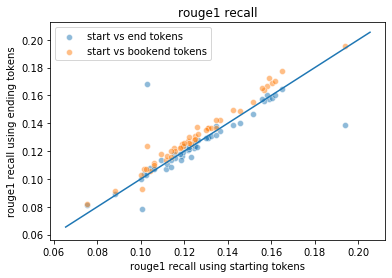

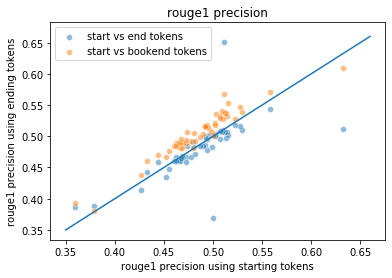

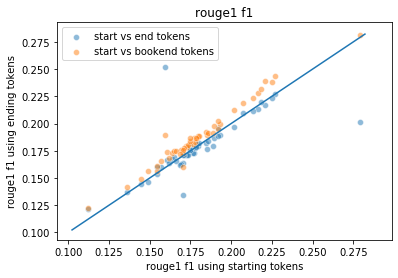

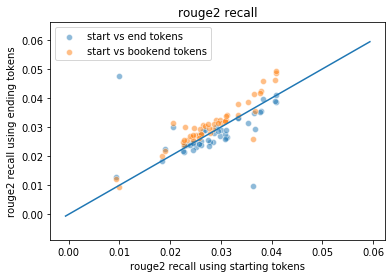

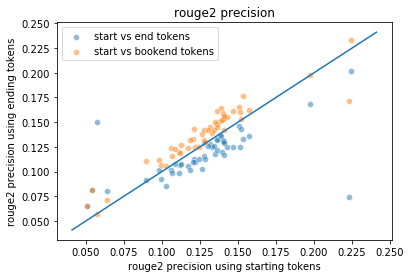

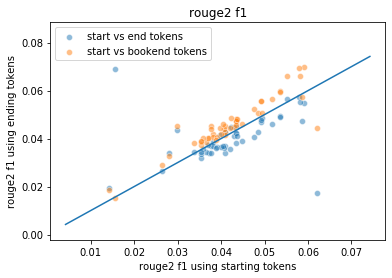

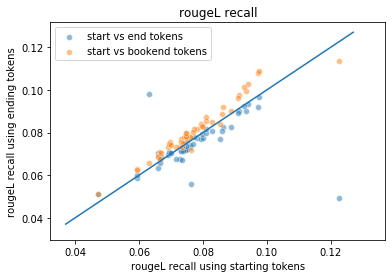

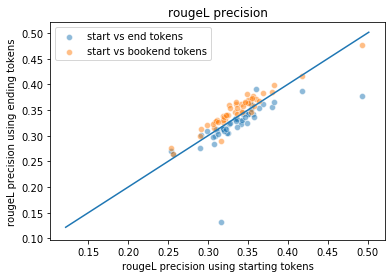

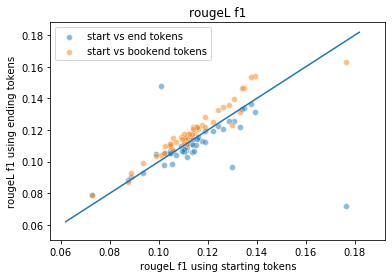

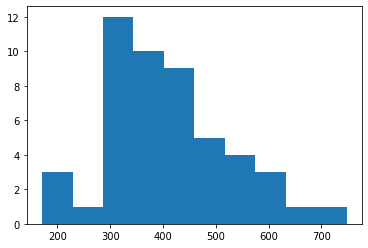

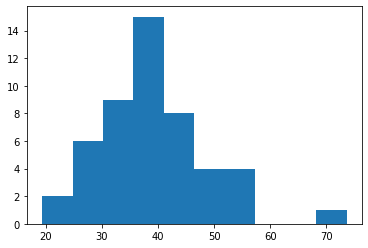

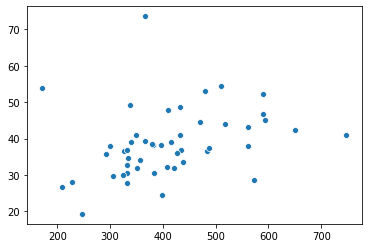

In [23]:
for r in ['rouge1', 'rouge2', 'rougeL']:
    for m in ['recall', 'precision', 'f1']:
        
        s = [score['start'][m][r] for sr, score in subreddit_scores.items()]
        e = [score['end'][m][r] for sr, score in subreddit_scores.items()]
        be = [score['bookend'][m][r] for sr, score in subreddit_scores.items()]
        sns.scatterplot(x=s, y=e, label='start vs end tokens', alpha=0.5)
        sns.scatterplot(x=s, y=be, label='start vs bookend tokens', alpha=0.5)
        
        plt.xlabel(f'{r} {m} using starting tokens')
        plt.ylabel(f'{r} {m} using ending tokens')
        identity = np.arange(min(min(s), min(e), min(be)) - 0.01, max(max(s), max(e), max(be)) + 0.01, 0.01)
        sns.lineplot(x=identity, y=identity)
        plt.title(f'{r} {m}')
        plt.legend()
        plt.show()
        
plt.hist([score['avg_content_len'] for sr, score in subreddit_scores.items()])
plt.show()
plt.hist([score['avg_summary_len'] for sr, score in subreddit_scores.items()])
plt.show()

sns.scatterplot([score['avg_content_len'] for sr, score in subreddit_scores.items()],
                [score['avg_summary_len'] for sr, score in subreddit_scores.items()])



In [22]:
[(sr, score) for sr, score in subreddit_scores.items() if score['bookend']['f1']['rouge2']>0.04]



[('AskReddit',
  {'start': {'recall': {'rouge1': 0.11918313792472872,
     'rouge2': 0.03109409205024234,
     'rougeL': 0.07461580085148051,
     'rougeLsum': 0.07880821612354601},
    'precision': {'rouge1': 0.5132907546742835,
     'rouge2': 0.1469692865739558,
     'rougeL': 0.35703665456610884,
     'rougeLsum': 0.3652173170848537},
    'f1': {'rouge1': 0.17717652460129651,
     'rouge2': 0.047639900268465936,
     'rougeL': 0.11410677584532808,
     'rougeLsum': 0.11902764287207687}},
   'end': {'recall': {'rouge1': 0.11652249997585577,
     'rouge2': 0.026737877676477277,
     'rougeL': 0.07235404909293172,
     'rougeLsum': 0.07620198745067433},
    'precision': {'rouge1': 0.4978375235718714,
     'rouge2': 0.12517261582010297,
     'rougeL': 0.3424788633962865,
     'rougeLsum': 0.349513855643356},
    'f1': {'rouge1': 0.17314894096711722,
     'rouge2': 0.04067319034220698,
     'rougeL': 0.1105427444589707,
     'rougeLsum': 0.11484351589008235}},
   'bookend': {'recall': {'